# Yet another attempt at implementing fisherface

## Implementation

In [8]:
# import warnings
import numpy as np
from scipy import linalg
# from scipy.special import expit

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
# from sklearn.linear_model._base import LinearClassifierMixin
from sklearn.covariance import ledoit_wolf, empirical_covariance, shrunk_covariance
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_is_fitted
# from sklearn.utils.multiclass import check_classification_targets
# from sklearn.utils.extmath import softmax
from sklearn.preprocessing import StandardScaler

In [88]:
from sklearn.discriminant_analysis import _cov, _class_cov, _class_means

# def _cov(X, shrinkage=None, covariance_estimator=None):
#     """Estimate covariance matrix (using optional covariance_estimator).
#     Parameters
#     """
#     if covariance_estimator is None:
#         shrinkage = "empirical" if shrinkage is None else shrinkage
#         if isinstance(shrinkage, str):
#             if shrinkage == "auto":
#                 sc = StandardScaler()  # standardize features
#                 X = sc.fit_transform(X)
#                 s = ledoit_wolf(X)[0]
#                 # rescale
#                 s = sc.scale_[:, np.newaxis] * s * sc.scale_[np.newaxis, :]
#             elif shrinkage == "empirical":
#                 s = empirical_covariance(X)
#             else:
#                 raise ValueError("unknown shrinkage parameter")
#         elif isinstance(shrinkage, float) or isinstance(shrinkage, int):
#             if shrinkage < 0 or shrinkage > 1:
#                 raise ValueError("shrinkage parameter must be between 0 and 1")
#             s = shrunk_covariance(empirical_covariance(X), shrinkage)
#         else:
#             raise TypeError("shrinkage must be a float or a string")
#     else:
#         if shrinkage is not None and shrinkage != 0:
#             raise ValueError(
#                 "covariance_estimator and shrinkage parameters "
#                 "are not None. Only one of the two can be set."
#             )
#         covariance_estimator.fit(X)
#         if not hasattr(covariance_estimator, "covariance_"):
#             raise ValueError(
#                 "%s does not have a covariance_ attribute"
#                 % covariance_estimator.__class__.__name__
#             )
#         s = covariance_estimator.covariance_
#     return s


# def _class_means(X, y):
#     """Compute class means.
#     """
#     classes, y = np.unique(y, return_inverse=True)
#     cnt = np.bincount(y)
#     means = np.zeros(shape=(len(classes), X.shape[1]))
#     np.add.at(means, y, X)
#     means /= cnt[:, None]
#     return means


# def _class_cov(X, y, priors, shrinkage=None, covariance_estimator=None):
#     """Compute weighted within-class covariance matrix.
#     The per-class covariance are weighted by the class priors.
#     """
#     classes = np.unique(y)
#     cov = np.zeros(shape=(X.shape[1], X.shape[1]))
#     for idx, group in enumerate(classes):
#         Xg = X[y == group, :]
#         cov += priors[idx] * np.atleast_2d(_cov(Xg, shrinkage, covariance_estimator))
#     return cov


In [ ]:
class FisherLD(BaseEstimator):
    def __init__(self, n_components=None, shrinkage=None, priors=None):
        """Initialize Fisher's Linear Discriminant.

        Args:
            n_components (int, optional): number of components of projection.
                maximum possible used if not provided. Defaults to None.
            shrinkage (str, float, None): shrinkage for the covariance estimator.
                'auto': (automatic shrinkage using Ledoit-Wolf lemma)
                float: fixed shrinkage constant between 0 and 1 and
                None: no shrinkage
            priors (List[float], optional): class priors.
                calculated automatically if not provided. Defaults to None.
        """

        self.shrinkage = shrinkage
        self.priors = priors
        self.n_components = n_components

    def _solve_eigen(self, X, y, shrinkage):
        """
        Solve the generalized eigenvector problem.
        Finds the generalized eigenvectors for the within-class and
        between-class scatter matrix to find directions which maximize
        separation between classes.

        Args:
            X (np.ndarray): training data of shape (n_samples, n_features)
            y (List[int]): training labels of shape (n_samples,)
            shrinkage (str, float, None): shrinkage for the covariance estimator.
                'auto': (automatic shrinkage using Ledoit-Wolf lemma)
                float: fixed shrinkage constant between 0 and 1 and
                None: no shrinkage
        """

        self.class_means_ = _class_means(X, y)
        self.class_cov_ = _class_cov(
            X, y, self.priors_, shrinkage, covariance_estimator=None
        )


        # TODO: can we implement this in such a way that the generalization *interpolates* between eigenface and fisherface!?
        S_w = self.class_cov_  # within-class scatter matrix
        S_t = _cov(X, shrinkage, covariance_estimator=None)  # total scatter matrix
        S_b = S_t - S_w  # between-class scatter matrix

        # solve generalized eigenvector problem
        eigen_vals, eigen_vecs = linalg.eigh(S_b, S_w) # S_b v_i = lambda_i S_w v_i

        # sort eigenvalues and eigenvectors
        eigen_vals = np.sort(eigen_vals)[::-1]
        eigen_vecs = eigen_vecs[:, np.argsort(eigen_vals)[::-1]]

        self.eigen_vals_ = eigen_vals
        self.eigen_vecs_ = eigen_vecs

        # calculate the explained varaince ratio
        self.explained_variance_ratio = eigen_vals[:self._max_components] / np.sum(eigen_vals)

        # define transformation matrix
        self.transformation_matrix_ = eigen_vecs


    # NOTE: SVD solver seems to be much less prone to overfitting and doesn't require pca-first.
    # TODO figure out why. perhaps implement (though it doesn't use within-class between-class scatter.)

    def fit(self, X, y):
        """
        Fit the fisher's linear discriminant model.

        Args:
            X (np.ndarray): training data of shape (n_samples, n_features)
            y (List[int]): training labels of shape (n_samples,)

        Returns:
            self: Fitted estimator
        """

        self.classes_ = unique_labels(y)
        n_samples, dim = X.shape
        n_classes = len(self.classes_)

        if self.priors is None:  # estimate priors from sample
            _, y_t = np.unique(y, return_inverse=True)  # non-negative ints
            self.priors_ = np.bincount(y_t) / float(len(y))
        else:
            self.priors_ = np.asarray(self.priors)


        # the maximum number of components possible
        max_components = min(len(self.classes_) - 1, dim)

        # if `n_components` is not specified, use largest possible
        if self.n_components is None:
            self._max_components = max_components

        # if `n_components` is specified, check that it's valid
        else:
            if self.n_components > max_components:
                raise ValueError(
                    "n_components cannot be larger than min(n_features, n_classes - 1)."
                )
            self._max_components = self.n_components

        # solve generalized eigenvector problem
        self._solve_eigen( X, y, shrinkage=self.shrinkage)

        return self

    def transform(self, X):
        """
        Project data to linear subspace which maximizes classs separation.

        Args:
            X (np.ndarray): input data of shape (n_samples, n_features)

        Returns:
            np.ndarray: transformed data.
        """

        check_is_fitted(self) # only keep going model has already been fit

        X_new = np.dot(X, self.transformation_matrix_)

        return X_new[:, : self._max_components]

In [61]:
# import warnings
import numpy as np
from scipy import linalg

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.covariance import ledoit_wolf, empirical_covariance, shrunk_covariance
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import StandardScaler

from sklearn.discriminant_analysis import _cov, _class_cov, _class_means

class GeneralizedFisherLD(BaseEstimator):
    def __init__(self, n_components=None, alpha=0, shrinkage=None, priors=None):
        """Initialize Fisher's Linear Discriminant.

        Args:
            n_components (int, optional): number of components of projection.
                maximum possible used if not provided. Defaults to None.
            alpha (float, optional): alpha parameter in range [0,1].
                interpolates between fisherface and eigenface.
                0 corresponds to full fisherface, 1 corresponds to eigenface.
            shrinkage (str, float, None): shrinkage for the covariance estimator.
                'auto': (automatic shrinkage using Ledoit-Wolf lemma)
                float: fixed shrinkage constant between 0 and 1 and
                None: no shrinkage
            priors (List[float], optional): class priors.
                calculated automatically if not provided. Defaults to None.
        """

        self.n_components = n_components
        self.alpha = alpha
        self.shrinkage = shrinkage
        self.priors = priors

    def _solve_eigen(self, X, y, shrinkage):
        """
        Solve the generalized eigenvector problem.
        Finds the generalized eigenvectors for the within-class and
        between-class scatter matrix to find directions which maximize
        separation between classes.

        Args:
            X (np.ndarray): training data of shape (n_samples, n_features)
            y (List[int]): training labels of shape (n_samples,)
            shrinkage (str, float, None): shrinkage for the covariance estimator.
                'auto': (automatic shrinkage using Ledoit-Wolf lemma)
                float: fixed shrinkage constant between 0 and 1 and
                None: no shrinkage
        """

        self.class_means_ = _class_means(X, y)
        self.class_cov_ = _class_cov(
            X, y, self.priors_, shrinkage, covariance_estimator=None
        )


        # TODO: can we implement this in such a way that the generalization *interpolates* between eigenface and fisherface!?
        S_w = self.class_cov_  # within-class scatter matrix
        S_t = _cov(X, shrinkage, covariance_estimator=None)  # total scatter matrix
        S_b = S_t - S_w  # between-class scatter matrix

        # calculate the A_matrix and B_matrix
        A_matrix = S_b # TODO: add beta parameter to interpolate S_b??
        B_matrix = self.alpha * np.identity(np.shape(S_w)[0]) + (1 - self.alpha)*S_w
        self.A_matrix_ = A_matrix # TEMP FIXME
        self.B_matrix_ = B_matrix

        # solve generalized eigenvector problem
        eigen_vals, eigen_vecs = linalg.eigh(A_matrix, B_matrix) # A v_i = lambda_i B v_i

        # sort eigenvalues and eigenvectors
        eigen_vals = np.sort(eigen_vals)[::-1]
        eigen_vecs = eigen_vecs[:, np.argsort(eigen_vals)[::-1]]

        self.eigen_vals_ = eigen_vals
        self.eigen_vecs_ = eigen_vecs

        # calculate the explained varaince ratio
        self.explained_variance_ratio = eigen_vals[:self._max_components] / np.sum(eigen_vals)

        # define transformation matrix
        self.transformation_matrix_ = eigen_vecs


    # NOTE: SVD solver seems to be much less prone to overfitting and doesn't require pca-first.
    # TODO figure out why. perhaps implement (though it doesn't use within-class between-class scatter.)

    def fit(self, X, y):
        """
        Fit the fisher's linear discriminant model.

        Args:
            X (np.ndarray): training data of shape (n_samples, n_features)
            y (List[int]): training labels of shape (n_samples,)

        Returns:
            self: Fitted estimator
        """

        self.classes_ = unique_labels(y)
        n_samples, dim = X.shape
        n_classes = len(self.classes_)

        if self.priors is None:  # estimate priors from sample
            _, y_t = np.unique(y, return_inverse=True)  # non-negative ints
            self.priors_ = np.bincount(y_t) / float(len(y))
        else:
            self.priors_ = np.asarray(self.priors)


        # the maximum number of components possible
        max_components = min(len(self.classes_) - 1, dim)

        # if `n_components` is not specified, use largest possible
        if self.n_components is None:
            self._max_components = max_components

        # if `n_components` is specified, check that it's valid
        else:
            if self.n_components > max_components:
                raise ValueError(
                    "n_components cannot be larger than min(n_features, n_classes - 1)."
                )
            self._max_components = self.n_components

        # solve generalized eigenvector problem
        self._solve_eigen( X, y, shrinkage=self.shrinkage)

        return self

    def transform(self, X):
        """
        Project data to linear subspace which maximizes classs separation.

        Args:
            X (np.ndarray): input data of shape (n_samples, n_features)

        Returns:
            np.ndarray: transformed data.
        """

        check_is_fitted(self) # only keep going model has already been fit

        X_new = np.dot(X, self.transformation_matrix_)

        return X_new[:, : self._max_components]

## Tests

In [1]:
# load data
import sklearn.datasets
from sklearn.model_selection import train_test_split


lfw_people = sklearn.datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4)

n_samples, h, w = lfw_people.images.shape
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target


print("Total dataset size:")
print("n_samples: ",  n_samples)
print("n_features: ", n_features)
print("n_classes: ", n_classes)


# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# first, scale the data
scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train_trfm = scaler.transform(X_train)
X_test_trfm = scaler.transform(X_test)

Total dataset size:
n_samples:  1288
n_features:  1850
n_classes:  7


In [9]:
N = len(X_train)
c = len(np.unique(y))
dim = X_train.shape[1]

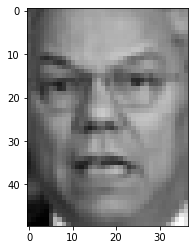

In [ ]:
# show a random image sample
import matplotlib.pyplot as plt
sample_img = lfw_people.images[np.random.choice(range(n_samples))]
plt.imshow(sample_img, cmap='gray')

In [14]:
# fld = GeneralizedFisherLD(n_components=c-1, solver='svd')
# fld.fit(X_train_trfm, y_train)

TypeError: __init__() got an unexpected keyword argument 'solver'

In [36]:
import sklearn.pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

fld_clf = sklearn.pipeline.Pipeline(steps=[('pca', PCA(n_components=N-(c-1))),
                                           ('fld', FisherLD(n_components=c-1, shrinkage='auto')),
                                           ('KNN', KNeighborsClassifier(n_neighbors=5))])
fld_clf.fit(X_train_trfm, y_train)

Pipeline(steps=[('pca', PCA(n_components=960)),
                ('fld', FisherLD(n_components=6, shrinkage='auto')),
                ('KNN', KNeighborsClassifier())])

In [37]:
print('train acc: ', fld_clf.score(X_train_trfm, y_train))
print('test acc: ', fld_clf.score(X_test_trfm, y_test))

train acc:  0.468944099378882
test acc:  0.38509316770186336


In [33]:
import sklearn.pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

fld_clf = sklearn.pipeline.Pipeline(steps=[('pca', PCA(n_components=N-(c-1))),
                                           ('fld', FisherLD(n_components=c-1)),
                                           ('svm', SVC(kernel='rbf'))])
fld_clf.fit(X_train_trfm, y_train)

Pipeline(steps=[('pca', PCA(n_components=960)),
                ('fld', FisherLD(n_components=6)), ('svm', SVC())])

In [34]:
print('train acc: ', fld_clf.score(X_train_trfm, y_train))
print('test acc: ', fld_clf.score(X_test_trfm, y_test))

train acc:  0.4409937888198758
test acc:  0.4440993788819876


In [93]:
import sklearn.pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

fld_clf = sklearn.pipeline.Pipeline(steps=[('pca', PCA(n_components=N-(c-1))),
                                           ('fld', FisherLD(n_components=c-1, solver='eigen', shrinkage='empirical')),
                                           ('rf', RandomForestClassifier())])
fld_clf.fit(X_train_trfm, y_train)

TypeError: __init__() got an unexpected keyword argument 'solver'

In [94]:
W_ff = fld_clf[1].scalings_ @ fld_clf[0].components_

AttributeError: 'RandomForestClassifier' object has no attribute 'scalings_'

In [95]:
fld_clf[1].scalings_

AttributeError: 'RandomForestClassifier' object has no attribute 'scalings_'

In [68]:
W_ff[:,0].shape

(960,)

In [70]:
W_ff.shape

(960, 1850)

In [73]:
W_ff[0,:].shape

(1850,)

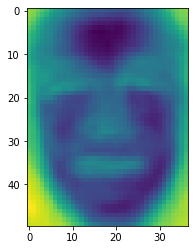

In [87]:
# fisherfaces!

plt.imshow(W_ff[0,:].reshape(50, 37))

In [61]:
print('train acc: ', fld_clf.score(X_train_trfm, y_train))
print('test acc: ', fld_clf.score(X_test_trfm, y_test))

train acc:  1.0
test acc:  0.4472049689440994


In [89]:
import sklearn.pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

fld_clf = sklearn.pipeline.Pipeline(steps=[#('pca', PCA(n_components=N-(c-1))),
                                           ('fld', FisherLD(n_components=c-1, shrinkage='auto')),
                                           ('rf', RandomForestClassifier())])
fld_clf.fit(X_train_trfm, y_train)

Pipeline(steps=[('fld', FisherLD(n_components=6, shrinkage='auto')),
                ('rf', RandomForestClassifier())])

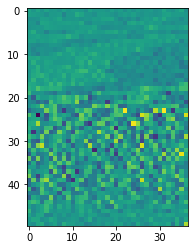

In [92]:
import matplotlib.pyplot as plt
plt.imshow(fld_clf[0].transformation_matrix_[0,:].reshape(50,37))

In [63]:
print('train acc: ', fld_clf.score(X_train_trfm, y_train))
print('test acc: ', fld_clf.score(X_test_trfm, y_test))

train acc:  1.0
test acc:  0.43788819875776397


In [82]:
import sklearn.pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

eigface_clf = sklearn.pipeline.Pipeline(steps=[('pca', PCA(n_components=c-1)),
                                        #    ('fld', GeneralizedFisherLD(n_components=c-1, alpha=1, shrinkage='auto')),
                                           ('rf', RandomForestClassifier())])
eigface_clf.fit(X_train_trfm, y_train)

Pipeline(steps=[('pca', PCA(n_components=6)), ('rf', RandomForestClassifier())])

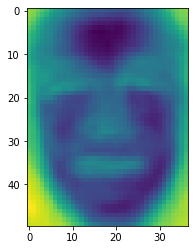

In [88]:
plt.imshow(eigface_clf[0].components_[0,:].reshape(50,37))

In [56]:
print('train acc: ', eigface_clf.score(X_train_trfm, y_train))
print('test acc: ', eigface_clf.score(X_test_trfm, y_test))

train acc:  1.0
test acc:  0.4937888198757764


-------------------------

In [6]:
from generalized_fisherface_eigen import FisherLD

In [11]:
import sklearn.pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

fld_clf = sklearn.pipeline.Pipeline(steps=[('pca', PCA(n_components=N-(c-1))),
                                           ('fld', FisherLD(n_components=c-1, shrinkage='empirical')),
                                           ('rf', RandomForestClassifier())])
fld_clf.fit(X_train_trfm, y_train)

Pipeline(steps=[('pca', PCA(n_components=960)),
                ('fld', FisherLD(n_components=6, shrinkage='empirical')),
                ('rf', RandomForestClassifier())])